<a href="https://colab.research.google.com/github/AmonTonui/Final_Year_Project/blob/main/1stSOM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  # Install Intrasom
  !pip install minisom

LOCAL_DEV = True
if LOCAL_DEV:
    sys.path.insert(0, '../')
    %load_ext autoreload

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=f1e3b884ab773a9285a015ff8c6f1c220a3b42aa75dbf3fecf6f8a07de53c076
  Stored in directory: /root/.cache/pip/wheels/19/db/95/5e53bc2b88a328217fdf9f2886cafbe86b0df274f4b601f572
Successfully built minisom


Data Preprocessing and Feature Scaling

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from minisom import MiniSom
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize

data = pd.read_csv("Educationmergednormalized_with_winners_cleaned2024.csv")

filtered_data = data[data['Winning Party'].isin(['Labour', 'Conservative'])]
filtered_data = filtered_data.reset_index(drop=True)


party_colors = {
    'Conservative': (0, 0, 1),    # Blue
    'Labour': (1, 0, 0),          # Red
    # 'Liberal Democrat': (0.98, 0.6, 0.1),  # Orange
    # 'Green': (0, 0.6, 0.3),         # Dark Green
    # 'The Brexit Party': (0.6, 0.2, 0.8) #light blue

}


#Data with Labels that I will use to map the result clusters
labeling_columns = ['Westminster Parliamentary constituencies', 'Winning Party', 'Winning Vote Share']
features = filtered_data.drop(columns=labeling_columns)



robust_scaler = RobustScaler()
normalized_features = robust_scaler.fit_transform(features)



normalized_df = pd.DataFrame(normalized_features, columns=features.columns)
normalized_df[labeling_columns] = filtered_data[labeling_columns]

print(normalized_df.head())
print(normalized_df.shape[0])
print(normalized_df.isnull().sum())

   Level 1 and entry level qualifications: 1 to 4 GCSEs grade A* to C, Any GCSEs at other grades, O levels or CSEs (any grades), 1 AS level, NVQ level 1, Foundation GNVQ, Basic or Essential Skills  \
0                                           0.826071                                                                                                                                                   
1                                           0.349697                                                                                                                                                   
2                                          -1.449673                                                                                                                                                   
3                                           0.623259                                                                                                                                                   


Initialing SOM Algorithm and Training

In [3]:
# import math
# Initialize and Train SOM
n_neurons = int(np.sqrt(5 * np.sqrt(normalized_features.shape[0])))
# n_neurons = int(math.ceil(5*np.sqrt(normalized_features.shape[0])))
m_neurons = n_neurons

som = MiniSom(n_neurons, m_neurons, normalized_features.shape[1], sigma=1.07555, learning_rate=0.436,
              neighborhood_function='gaussian', random_seed=0, topology='rectangular')


som.random_weights_init(normalized_features)

# Train the SOM
num_iterations = 4500
som.train(normalized_features, num_iterations, verbose=True)

# Assign winning neurons (Best Matching Units - BMUs) for each data point
winning_neurons = [som.winner(x) for x in normalized_features]
normalized_df['Neuron Row'] = [wn[0] for wn in winning_neurons]
normalized_df['Neuron Col'] = [wn[1] for wn in winning_neurons]

print(n_neurons, m_neurons)




 [ 4500 / 4500 ] 100% - 0:00:00 left 
 quantization error: 0.4014727288467335
9 9


In [4]:
def topographic_error(som, data):
    error_count = 0
    for x in data:
        bmu = som.winner(x)
        distances = np.linalg.norm(som.get_weights() - x, axis=2)
        second_bmu = np.unravel_index(np.argsort(distances.ravel())[1], distances.shape)

        if abs(bmu[0] - second_bmu[0]) > 1 or abs(bmu[1] - second_bmu[1]) > 1:
            error_count += 1
    return error_count / len(data)

te = topographic_error(som, normalized_features)
print(f"Topographic Error: {te}")

Topographic Error: 0.1910828025477707


Plot the 2D SOM

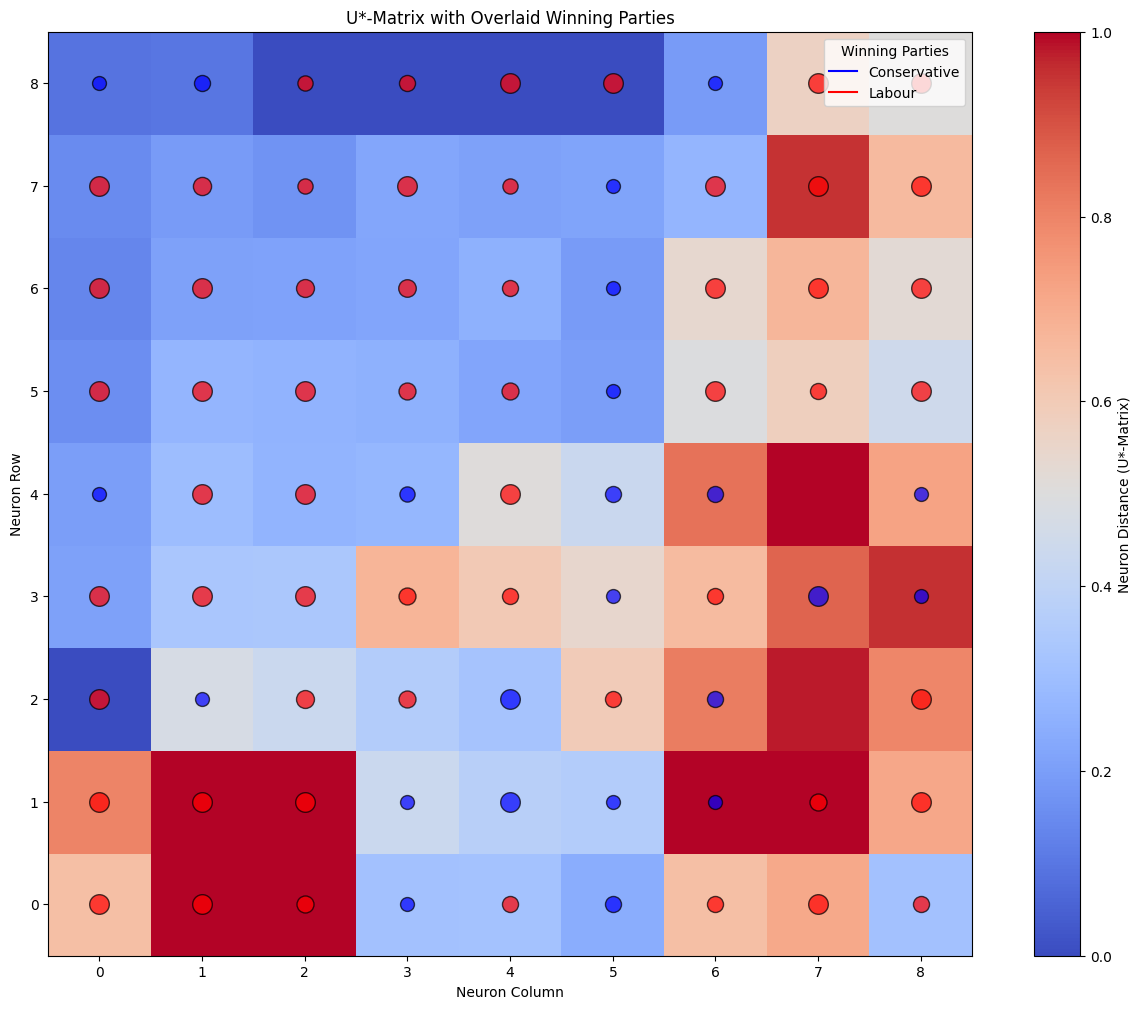

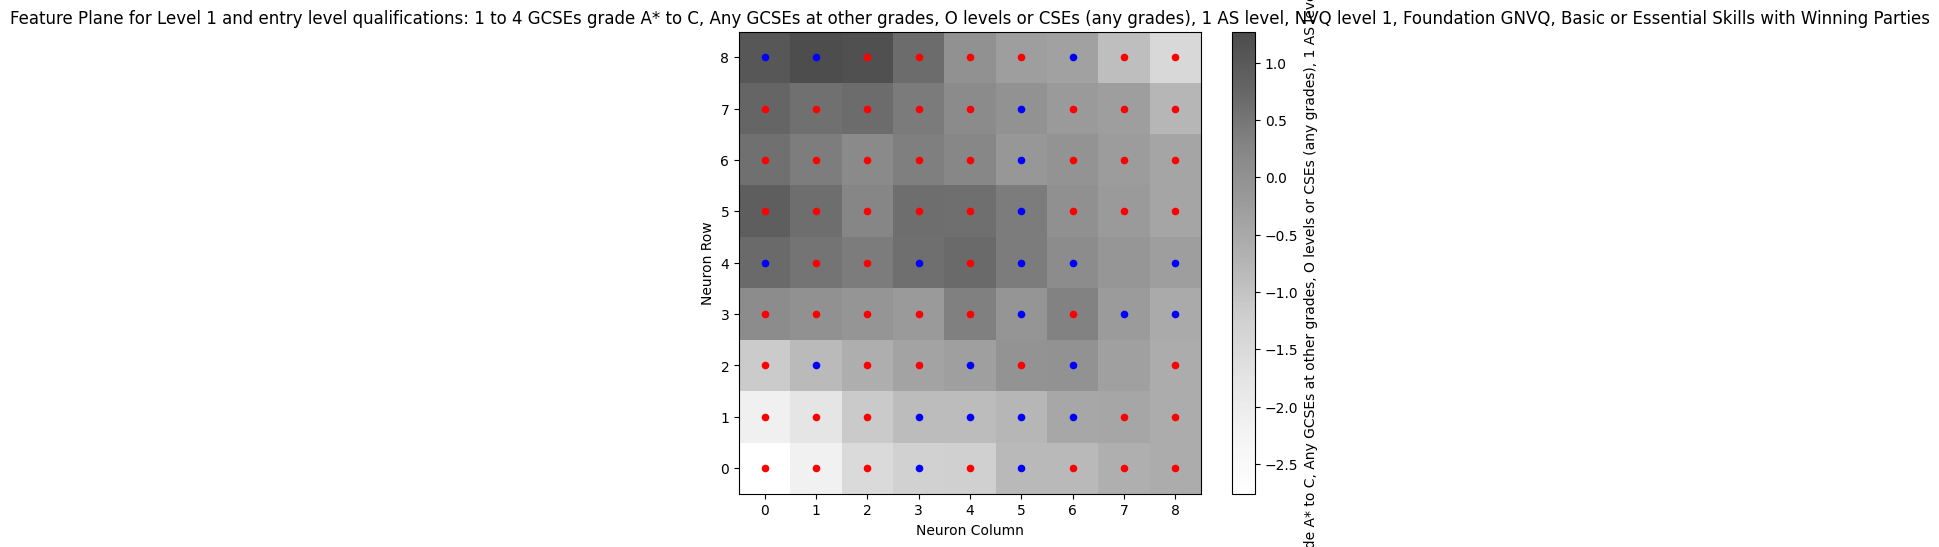

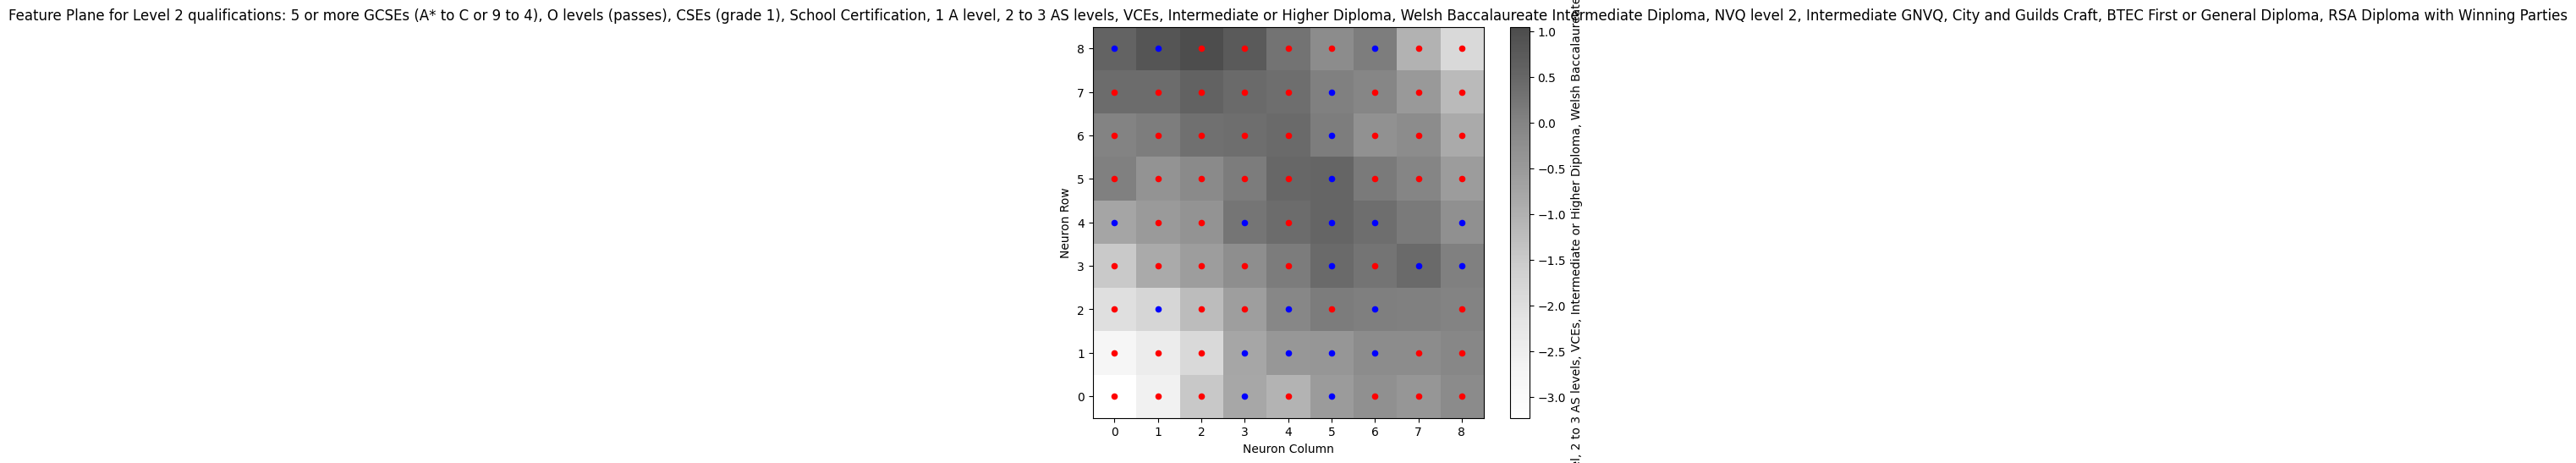

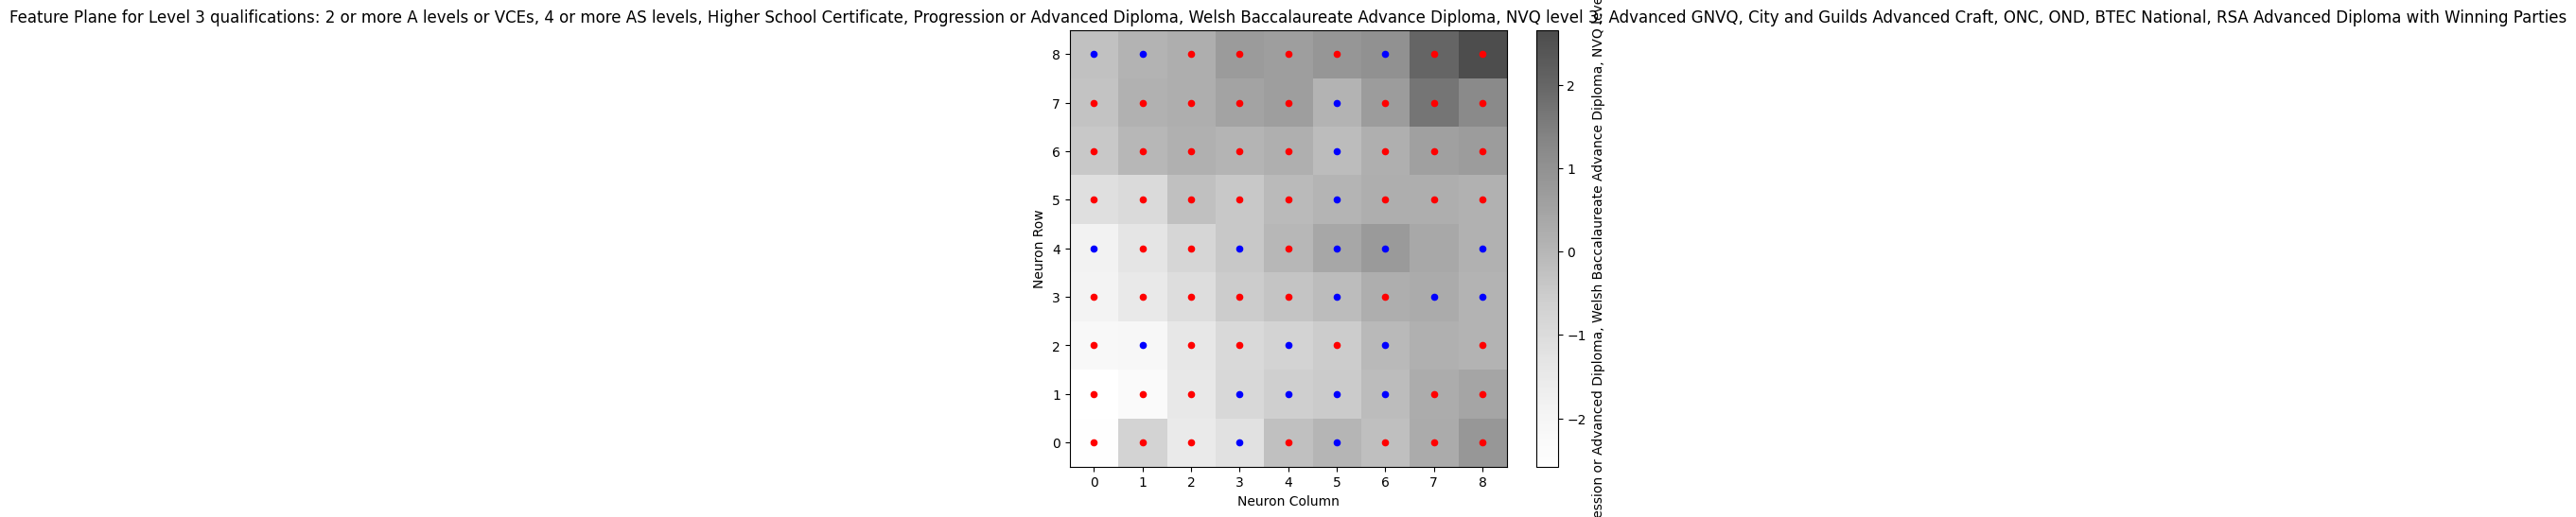

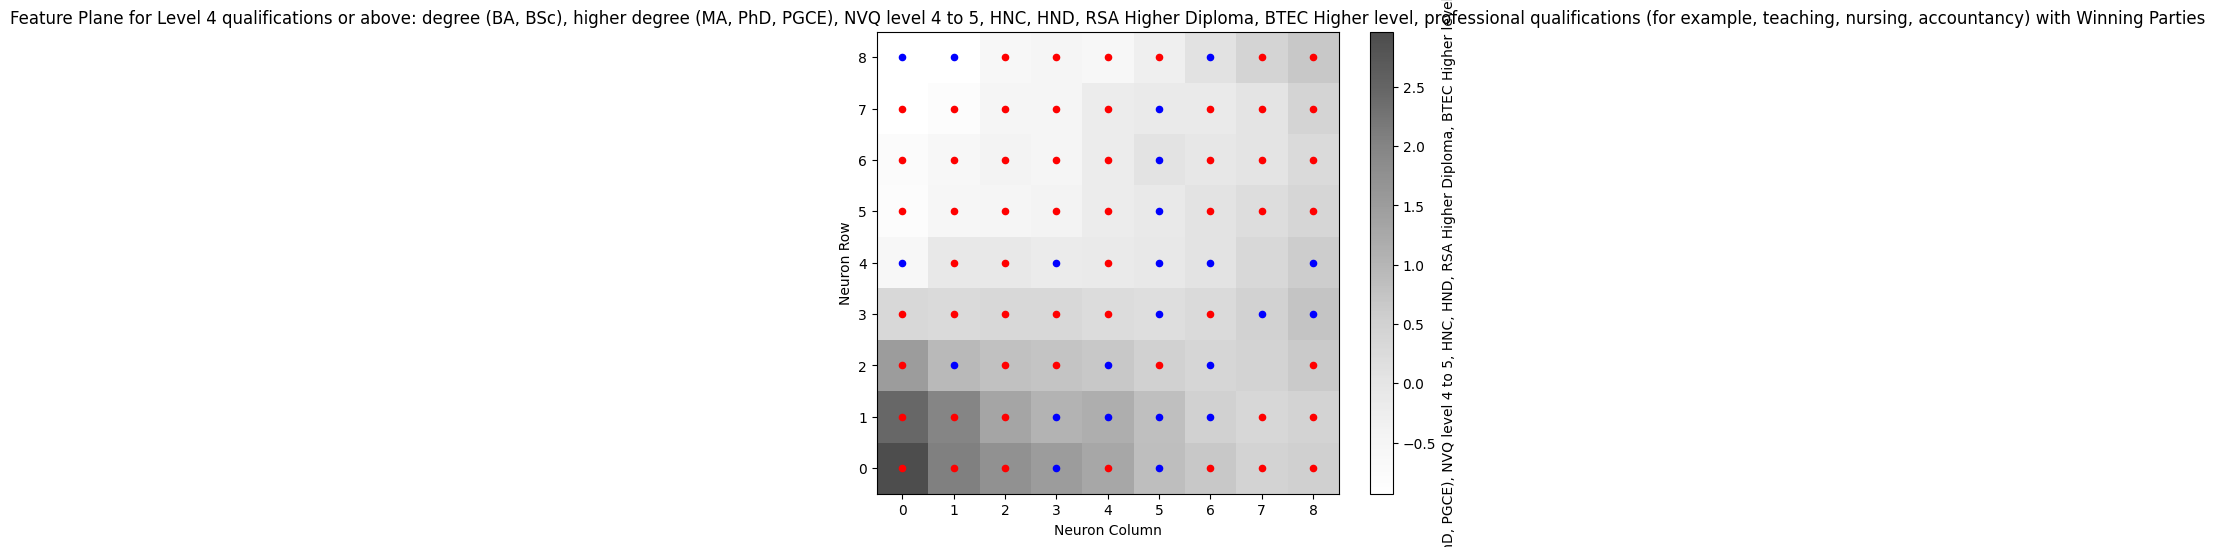

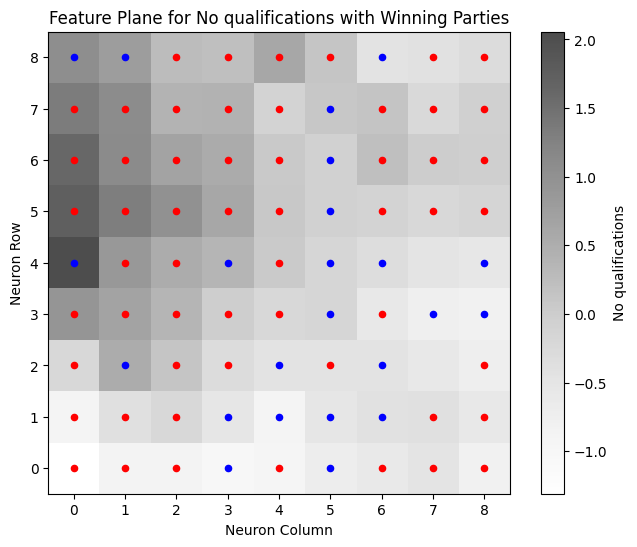

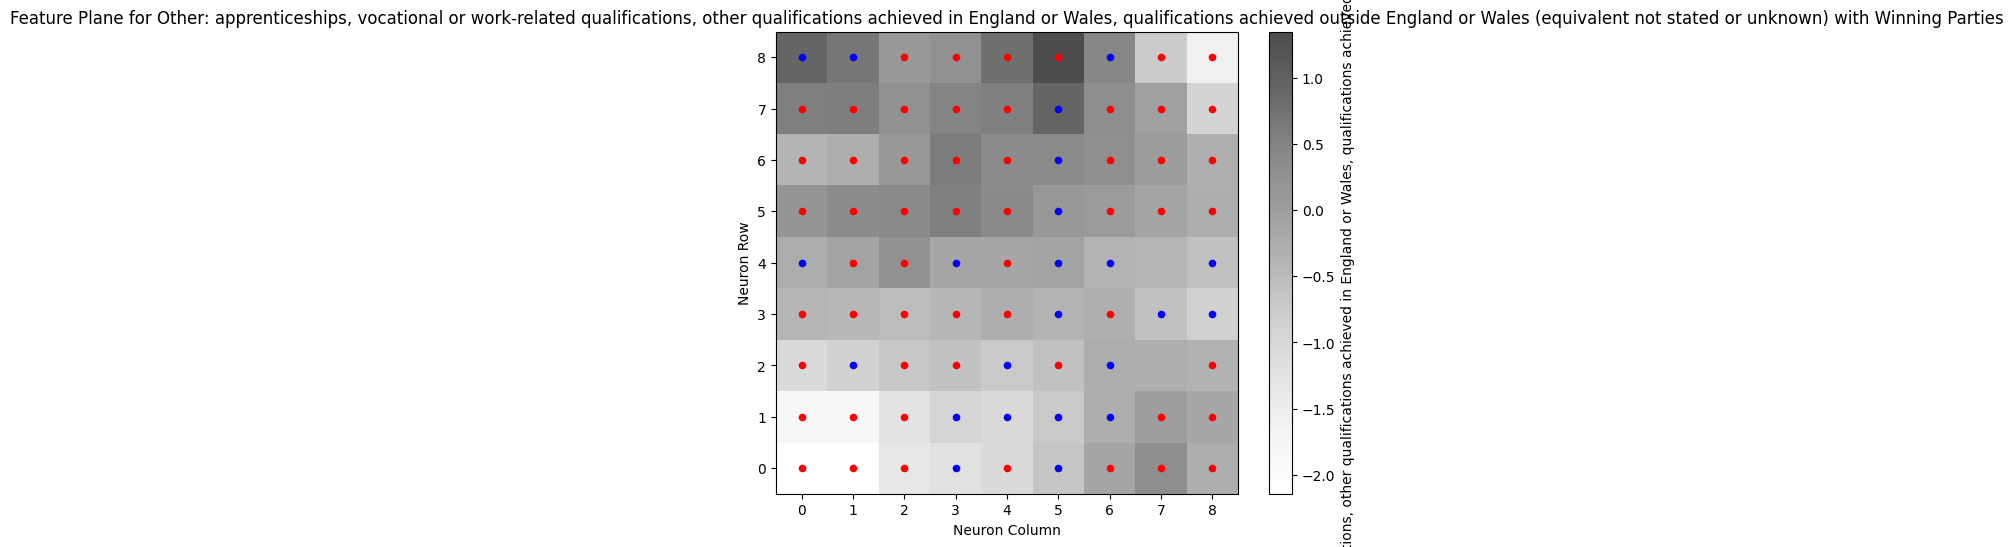

Neuron (4, 4): ['aldershot', 'ashford', 'hastings and rye', 'stevenage']
Neuron (6, 2): ['aldridgebrownhills', 'birkenhead', 'halifax', 'st helens north', 'st helens south and whiston', 'stourbridge']
Neuron (0, 3): ['altrincham and sale west', 'south west hertfordshire']
Neuron (7, 3): ['amber valley', 'chesterfield', 'erewash', 'north durham', 'north east derbyshire', 'portsmouth north', 'rother valley', 'stalybridge and hyde', 'stockton north']
Neuron (3, 7): ['arundel and south downs', 'east surrey', 'south northamptonshire']
Neuron (7, 1): ['ashtonunderlyne', 'bolsover', 'easington', 'houghton and sunderland south', 'louth and horncastle', 'mansfield', 'sheffield south east']
Neuron (2, 6): ['aylesbury', 'central devon', 'huntingdon']
Neuron (3, 4): ['banbury', 'hemel hempstead', 'spelthorne']
Neuron (3, 1): ['barking', 'enfield north', 'slough']
Neuron (8, 5): ['barrow and furness']
Neuron (8, 2): ['basildon and billericay', 'braintree', 'chatham and aylesford', 'crawley', 'gilli

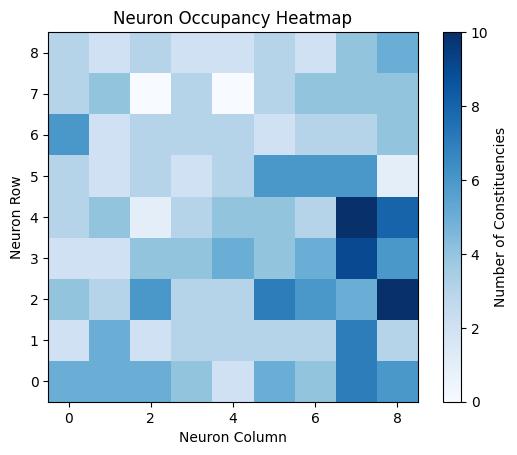

In [6]:
#U-Matrix implementation
from scipy.ndimage import median_filter

u_matrix = som.distance_map()
#plotting the two dimensional grid
density_matrix = np.zeros((n_neurons, m_neurons))

for r, c in zip(normalized_df['Neuron Row'], normalized_df['Neuron Col']):
    density_matrix[r, c] += 1  # Count occurrences

# Normalize density values to avoid division errors
density_matrix = median_filter(density_matrix, size=3)

# Step 3: Compute the U*-Matrix
min_p = np.min(density_matrix)
mean_p = np.mean(density_matrix)

if mean_p - min_p == 0:
    scale_factor = np.ones_like(density_matrix)
else:
    scale_factor = (density_matrix - min_p) / (mean_p - min_p)
u_star_matrix = u_matrix * scale_factor


party_counts = (normalized_df
                .groupby(['Neuron Row', 'Neuron Col', 'Winning Party'])
                .size()
                .unstack(fill_value=0))

dominant = party_counts.idxmax(axis=1)                # party with most seats
share    = party_counts.max(axis=1) / party_counts.sum(1)  # its proportion


labels_df = pd.concat([dominant.rename('major_party'),
                       share.rename('purity')], axis=1)
labels_df.to_csv('NeuronPurity.csv')


#plotting the two dimensional grid
plt.figure(figsize=(16, 12))
plt.title("U*-Matrix with Overlaid Winning Parties")
plt.imshow(u_star_matrix.T, cmap='coolwarm', origin='lower', vmin=0, vmax=1)
plt.colorbar(label="Neuron Distance (U*-Matrix)")

# Overlayying the winning parties on the grid
for (r, c), party in dominant.items():

    if party in party_colors:
        base_color = np.array(party_colors[party])
        plt.scatter(c,#neuron_row #+ 0.3 * np.random.rand(),
                    r,# neuron_col, #+ 0.3 * np.random.rand(),
                    s=200*share.loc[(r,c)],
                    color= base_color,#adjusted_color,
                    alpha=0.7, edgecolors='k',)


# Add legend
legend_elements = [Line2D([0], [0], color=color, label=party, markersize=10)
                   for party, color in party_colors.items()]
plt.legend(handles=legend_elements, loc='upper right', title="Winning Parties")
plt.xlabel("Neuron Column")
plt.ylabel("Neuron Row")
plt.show()



# 1. Feature Plane Visualization for Education Levels

# education_features = [
#     "Level 1 and entry level qualifications: 1 to 4 GCSEs grade A* to C, Any GCSEs at other grades, O levels or CSEs (any grades), 1 AS level, NVQ level 1, Foundation GNVQ, Basic or Essential Skills",
#     "Level 2 qualifications: 5 or more GCSEs (A* to C or 9 to 4), O levels (passes), CSEs (grade 1), School Certification, 1 A level, 2 to 3 AS levels, VCEs, Intermediate or Higher Diploma, Welsh Baccalaureate Intermediate Diploma, NVQ level 2, Intermediate GNVQ, City and Guilds Craft, BTEC First or General Diploma, RSA Diploma",
#     "Level 3 qualifications: 2 or more A levels or VCEs, 4 or more AS levels, Higher School Certificate, Progression or Advanced Diploma, Welsh Baccalaureate Advance Diploma, NVQ level 3; Advanced GNVQ, City and Guilds Advanced Craft, ONC, OND, BTEC National, RSA Advanced Diploma",
#     "Level 4 qualifications or above: degree (BA, BSc), higher degree (MA, PhD, PGCE), NVQ level 4 to 5, HNC, HND, RSA Higher Diploma, BTEC Higher level, professional qualifications (for example, teaching, nursing, accountancy)",
#     "No qualifications"
# ]

# # 2. Combining with Winning Party Colors

# for feature_name in education_features:
#     feature_index = features.columns.get_loc(feature_name)
#     feature_plane = som.get_weights()[:, :, feature_index]

#     plt.figure(figsize=(8, 6))
#     plt.imshow(feature_plane, cmap='Greys', origin='lower', alpha=0.7)
#     plt.colorbar(label=feature_name)
#     plt.title(f"Feature Plane for {feature_name} with Winning Parties")
#     plt.xlabel("Neuron Column")
#     plt.ylabel("Neuron Row")

#     for index, row in normalized_df.iterrows():
#         neuron_row, neuron_col = row['Neuron Row'], row['Neuron Col']
#         winning_party = row['Winning Party']
#         if winning_party in party_colors:
#           plt.scatter(neuron_col , neuron_row, color=party_colors.get(winning_party, 'gray'), marker='o', s=20)

#     plt.show()



#The feature planes plotted so as to see how each constituency votes based on the feature category
for feature_name in features.columns:
    feature_index = features.columns.get_loc(feature_name)
    feature_plane = som.get_weights()[:, :, feature_index]

    plt.figure(figsize=(8, 6))
    plt.imshow(feature_plane, cmap='Greys', origin='lower', alpha=0.7)
    plt.colorbar(label=feature_name)
    plt.title(f"Feature Plane for {feature_name} with Winning Parties")
    plt.xlabel("Neuron Column")
    plt.ylabel("Neuron Row")

    # for index, row in normalized_df.iterrows():
    for (r, c), party in dominant.items():
        # neuron_row, neuron_col = row['Neuron Row'], row['Neuron Col']
        # winning_party = row['Winning Party']
        colour = np.array(party_colors[party])
        if party in party_colors:
          plt.scatter(c, r, color=colour, marker='o', s=20)

    plt.show()

# Neuron-Constituency Mapping
neuron_constituency_map = {}
for index, row in normalized_df.iterrows():
    neuron = (row['Neuron Row'], row['Neuron Col'])
    constituency = row['Westminster Parliamentary constituencies']
    if neuron not in neuron_constituency_map:
        neuron_constituency_map[neuron] = []
    neuron_constituency_map[neuron].append(constituency)


for neuron, constituencies in neuron_constituency_map.items():
    print(f"Neuron {neuron}: {constituencies}")



normalized_df['Neuron'] = list(zip(normalized_df['Neuron Row'], normalized_df['Neuron Col']))
# Party Distribution of the winning neurons with its vote share dataset for analysis
grouped = normalized_df.groupby("Neuron").agg({
    'Winning Party': lambda x: x.value_counts().to_dict(),
    'Winning Vote Share': 'mean',
}).rename(columns={
    'Winning Party': 'Party Distribution',
    'Winning Vote Share': 'Avg Vote Share',
})

print(grouped.head())

grouped.to_csv('neuron_party_distribution.csv')

from matplotlib import pyplot as plt

hit_map = np.zeros((som._weights.shape[0], som._weights.shape[1]))
for x in normalized_features:
    bmu = som.winner(x)
    hit_map[bmu] += 1

plt.imshow(hit_map.T, cmap='Blues', origin='lower')
plt.colorbar(label='Number of Constituencies')
plt.title('Neuron Occupancy Heatmap')
plt.xlabel('Neuron Column')
plt.ylabel('Neuron Row')
plt.show()






In [15]:
#Clusters identified
valley_cells = {(2,3), (2,3), (1,3), (1,4), (1,5), (0,3), (0,4), (0,5)}

valley_df = normalized_df[
    normalized_df.apply(
        lambda r: (r['Neuron Row'], r['Neuron Col']) in valley_cells,
        axis=1
    )
][[
    'Westminster Parliamentary constituencies',
    'Winning Party',
    'Winning Vote Share'
]]

valley_df.to_csv("valley_constituencies.csv", index=False)
display(valley_df.head())

,Westminster Parliamentary constituencies,Winning Party,Winning Vote Share
10,barrow and furness,Labour,0.439047
11,basildon and billericay,Conservative,0.306357
28,bishop auckland,Labour,0.421402
41,braintree,Conservative,0.355185
56,cannock chase,Labour,0.364841


In [16]:
seat_counts  = valley_df['Winning Party'].value_counts()
purity       = seat_counts.max() / seat_counts.sum()

print("Seats by party:\n", seat_counts)
print(f"Purity = {purity:.1%}")


Seats by party:
 Winning Party
Labour          19
Conservative     6
Name: count, dtype: int64
Purity = 76.0%


In [12]:
feature_cols = features.columns #the features in the dataset
valley_features = normalized_df.loc[valley_df.index, feature_cols]

# mean of the observations  education level inside the valley
valley_profile = valley_features.mean()

print(valley_features)
print(valley_profile)

     Level 1 and entry level qualifications: 1 to 4 GCSEs grade A* to C, Any GCSEs at other grades, O levels or CSEs (any grades), 1 AS level, NVQ level 1, Foundation GNVQ, Basic or Essential Skills  \
10                                           -0.335756                                                                                                                                                   
11                                            1.293280                                                                                                                                                   
28                                           -0.178572                                                                                                                                                   
41                                            1.160133                                                                                                                                          